Integrating Particle filter with Epymorph
Trying to propagate particles using epymorph simulation each day

In [72]:
'''import required libraries'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from scipy.stats import poisson, norm
from sympy import Max

In [73]:
'''import functions to run epymorph'''
from epymorph import *
from epymorph.compartment_model import *
from epymorph.initializer import explicit
from functools import partial
from epymorph.initializer import single_location

In [74]:
'''constructing the seir ipm'''
def construct_ipm():
    symbols = create_symbols(
        compartments=[
            compartment('S'),
            compartment('E'),
            compartment('I'),
            compartment('R')
            #compartment('D')
        ],
        attributes=[
            param('beta', shape=Shapes.TxN),
            param('eta', shape=Shapes.TxN),
            param('gamma', shape=Shapes.TxN),
            #param('', shape=Shapes.TxN),
            param('µ', shape=Shapes.TxN),
            param('q')
        ])

    [S, E, I, R] = symbols.compartment_symbols
    [β, ξ, γ, µ, q] = symbols.attribute_symbols

    # formulate N so as to avoid dividing by zero;
    # this is safe in this instance because if the denominator is zero,
    # the numerator must also be zero
    #N = Max(1, S + E + I + R + D)
    N = 100000

    return create_model(
        symbols=symbols,
        transitions=[
            edge(S,E, rate=β * ((E + q * I) / N) * S),
            edge(E, I, rate=ξ * E ),
            edge(E, R, rate=γ * E),            
            edge(I, R, rate= γ * I)
            #edge(I, D, rate=µ * I)
        ]
    )

seir_ipm = construct_ipm()

In [75]:
class Particle:
    def __init__(self, seird, beta):
        self.seird = seird
        self.beta = beta

In [95]:
class ParticleFilter:
    def __init__(self, N, Np, beta_ranges, lambda_max, data, tmax):
        self.N = N 
        self.Np = Np
        self.beta_ranges = beta_ranges
        #self.gamma_ranges = gamma_ranges
        #self.eta_ranges = eta_ranges
        self.lambda_max = lambda_max
        self.data = data
        self.tmax = tmax
        self.beta_quantiles = []
        self.beta_values = []

    def initialize_particles(self):
        particles = []
        for _ in range(self.N):
            beta_0 = np.random.uniform(*self.beta_ranges)
            #gamma_0 = np.random.uniform(*self.gamma_ranges)
            #eta_0 = np.random.uniform(*self.eta_ranges)
            lambda_E_0 = np.random.randint(0, self.lambda_max)
            lambda_I_0 = np.random.randint(0, self.lambda_max)
            z_0 = np.array([[self.Np - lambda_E_0 - lambda_I_0, lambda_E_0, lambda_I_0, 0]], dtype=np.int64)
            #x_0 = z_0 * beta_0
            #theta_0 = np.array([gamma_0, eta_0])
            particles.append((z_0, beta_0))
        return particles
    
    '''select either of propagate_epimorph or propagate_particles_solver functions for particle propagation
       propagate_epimorph: propagate the particles using epymorph
       propagate_particles_solver: propagate the particles using the ode's'''
    def propagate_particles(self, particles):
        propagated_particles = []
        for x, beta_prev in particles:
            # Update particle cloud through some propagation process
            #propagated_x = self.propagate_epimorph(x, beta_prev)  # Placeholder for actual propagation
            propagated_x = self.propagate_particles_solver(x, beta_prev, self.Np)
            #print("propagated_x = ",propagated_x)
            #propagated_theta = theta  # Placeholder for actual propagation
            propagated_beta = np.exp(np.random.normal(np.log(beta_prev), 0.1))
            propagated_particles.append((propagated_x, propagated_beta))
        return propagated_particles

    '''epymorph simulation'''
    def propagate_epimorph(self, seird, beta):
        # Propagate particles using simulation
        
        params = {
            'beta': beta,
            'eta': 0.143,
            'gamma': 0.071,
            'µ': 0.004,
            'q': 0.1
        }
        
        sim = StandardSimulation(
            geo=geo_library['single_pop'](),
            ipm=seir_ipm,
            mm=mm_library['no'](),
            params=params,  # Use the provided params here
            time_frame=TimeFrame.of("2015-01-01", 1),
            initializer=partial(explicit, initials=seird)
        )
        output = sim.run()
        propagated_x = np.array(output.prevalence.tolist()[0], dtype=np.int64)
        return propagated_x

    '''propagate particles using ode's'''
    def propagate_particles_solver(self, z_prev, beta, Np):

        params = {
            'beta': beta,
            'eta': 0.143,
            'gamma': 0.071,
            'µ': 0.004,
            'q': 0.1
        }
        
        St, Et, It, Rt = z_prev[0]
        # Update equations based on the SE(A)IR model
        new_Et = Et + beta * ((Et + params['q'] * It)/Np) * St - params['eta'] * Et - params['gamma'] * Et
        new_It = It + (params['eta'] * Et) - (params['gamma'] * It) - (params['µ'] * It)
        new_St = St - beta * ((Et + params['q'] * It)/Np) * St
        new_Rt = Rt + (params['gamma'] * Et) + (params['gamma'] * It)
        #new_Dt = Dt + params['µ'] * It

        z_next = [new_St, new_Et, new_It, new_Rt]

        return np.array([z_next], dtype=np.int64)
    
    '''compute weights for each particle'''
    def compute_weights(self, b, particles):
        weights = np.zeros(self.N)
        for i in range(self.N):
            # Extract E_j from each propagated particle
            #print("particle = ",particles[i])
            E_j = particles[i][0][0][1]
            # Compute the weight for each particle
            weights[i] = poisson.pmf(b, 0.143 * E_j)
            #weight = (0.143 * E_j * datum) / (datum + 1) * np.exp(-0.143 * E_j)
        weights = weights/np.sum(weights)#normalize the weights
            
        return np.squeeze(weights)

    '''resample the particles based on the weights'''
    def resample_particles(self, particles, weights):
        resampled_particles = []
        # Sample with replacement N indices
        resampled_indices = np.random.choice(np.arange(self.N), size=self.N, replace=True, p=weights)
        for idx in resampled_indices:
            resampled_particles.append(particles[idx])
        return resampled_particles

    def update_weights(self, weights, new_weights):
        updated_weights = [new_weight * weight for weight, new_weight in zip(weights, new_weights)]
        return updated_weights
    
    def quantiles(self, items): 
        '''Returns 23 quantiles of the List passed in'''
        qtlMark = 1.00*np.array([0.010, 0.025, 0.050, 0.100, 0.150, 0.200, 0.250, 0.300, 0.350, 0.400, 0.450, 0.500, 0.550, 0.600, 0.650, 0.700, 0.750, 0.800, 0.850, 0.900, 0.950, 0.975, 0.990])
        return list(np.quantile(items, qtlMark))

    def run(self):
        particles = self.initialize_particles()
        
        #weights = np.ones(self.N) / self.N

        t = 0
        while t < self.tmax:
            print("Iteration: ",t)
            # (a) Propagate particles
            propagated_particles = self.propagate_particles(particles)
        
            # (b) Compute weights
            new_weights = self.compute_weights(self.data[t],propagated_particles)

            #print(new_weights)
            # (c) Resample particles
            particles = self.resample_particles(propagated_particles, new_weights)

            # (d) Update weights
            #weights = self.update_weights(weights, new_weights)
            weights = new_weights
            
            
            self.beta_quantiles.append(self.quantiles([particle[1] for particle in particles]))
            self.beta_values.append(np.mean([particle[1] for particle in particles]))

            # Advance the counter
            t += 1

        return particles, weights

In [97]:
data_path = "../datasets/calvetti_sim_data_protocol_A.csv"
data = pd.read_csv(data_path).to_numpy()
data = np.delete(data, 0, 1)

In [99]:
# Define parameters
N = 10000                                         # Number of particles
Np = 100_000                                     #Total population
beta_ranges = [0.1, 0.8]                         # Range for beta
lambda_max = 5                                   # Maximum value for lambda
tmax = len(data)                                 # Maximum time step

#gamma_ranges = [1/14, 1/7]  # Range for gamma
#eta_ranges = [1/14, 1/7]  # Range for eta

In [100]:
# Create ParticleFilter object

particle_filter = ParticleFilter(N, Np, beta_ranges, lambda_max, data, tmax)

In [101]:
# Run the particle filter algorithm

resampled_particles, weights = particle_filter.run()

Iteration:  0


C:\Users\sm4335\AppData\Local\Temp\ipykernel_9368\4221190663.py:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i] = poisson.pmf(b, 0.143 * E_j)


Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Iteration:  65
Iteration:  66
Iteration:  67
Iter

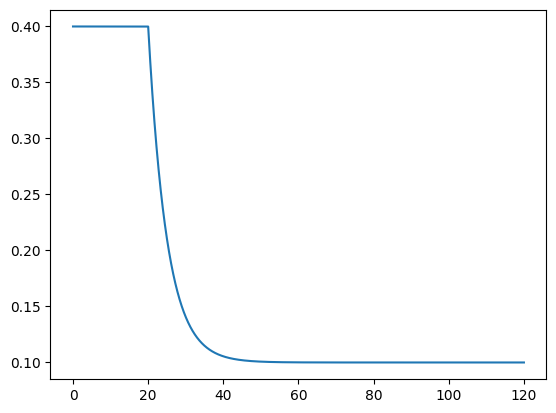

In [102]:
'''Functional beta'''
def beta(t,beta_par):

    if(t<beta_par['T']):
        return beta_par['beta_0']

    return beta_par['beta_inf'] + (beta_par['beta_0'] - beta_par['beta_inf']) * np.exp(-(t-beta_par['T'])/beta_par['tau'])
    
    
beta_par = {'beta_0':0.4,'beta_inf':0.1,'T':20,'tau':5} 
beta_ts = np.linspace(0,120,120000)

betas = []
for i in range(np.shape(beta_ts)[0]):
    betas.append(beta(beta_ts[i],beta_par))

plt.plot(beta_ts,np.array(betas))

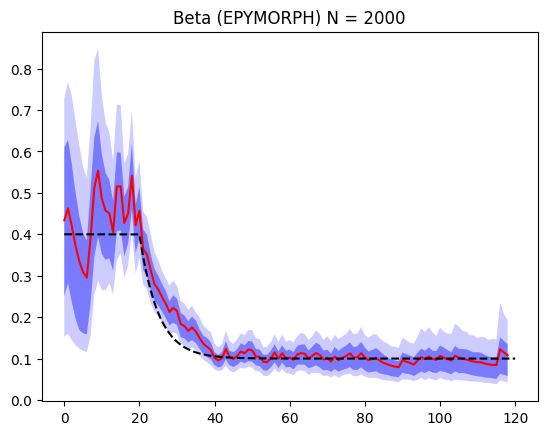

In [94]:
'''plotting the infection rate beta by propagating the particles using epymorph'''

pd.DataFrame(particle_filter.beta_values).to_csv('../datasets/average_beta.csv')
pd.DataFrame(particle_filter.beta_quantiles).to_csv('../datasets/beta_quantiles.csv')

pf_beta = pd.read_csv('../datasets/average_beta.csv').to_numpy()
pf_beta = np.delete(pf_beta, 0, 1)
beta_quantiles = pd.read_csv('../datasets/beta_quantiles.csv').to_numpy()
beta_quantiles = np.delete(beta_quantiles, 0, 1)

plt.title(f"Beta (EPYMORPH) N = {N}")
plt.fill_between(np.arange(0, 119), beta_quantiles[:, 3], beta_quantiles[:, 22 - 3], facecolor='blue', zorder=10, alpha=0.2)
plt.fill_between(np.arange(0, 119), beta_quantiles[:, 6], beta_quantiles[:, 22 - 6], facecolor='blue', zorder=11, alpha=0.4)
plt.plot(pf_beta, color="red", zorder=12)
plt.plot(beta_ts,np.array(betas),linestyle="dashed",zorder=12,color='black')
plt.savefig('Beta_epymorph.png')
plt.show()


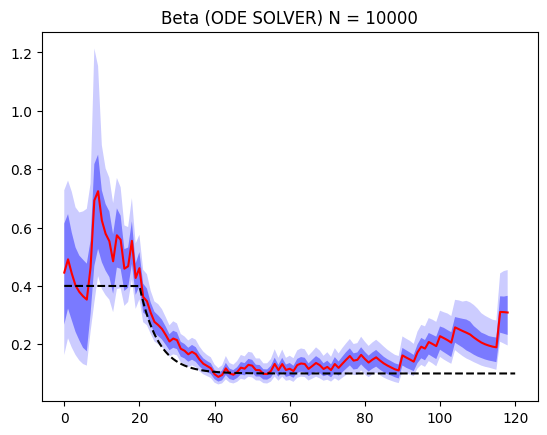

In [103]:
'''plotting the infection rate beta by propagating the particles using ode solver'''

pd.DataFrame(particle_filter.beta_values).to_csv('../datasets/average_beta.csv')
pd.DataFrame(particle_filter.beta_quantiles).to_csv('../datasets/beta_quantiles.csv')

pf_beta = pd.read_csv('../datasets/average_beta.csv').to_numpy()
pf_beta = np.delete(pf_beta, 0, 1)
beta_quantiles = pd.read_csv('../datasets/beta_quantiles.csv').to_numpy()
beta_quantiles = np.delete(beta_quantiles, 0, 1)

plt.title(f"Beta (ODE SOLVER) N = {N}")
plt.fill_between(np.arange(0, 119), beta_quantiles[:, 3], beta_quantiles[:, 22 - 3], facecolor='blue', zorder=10, alpha=0.2)
plt.fill_between(np.arange(0, 119), beta_quantiles[:, 6], beta_quantiles[:, 22 - 6], facecolor='blue', zorder=11, alpha=0.4)
plt.plot(pf_beta, color="red", zorder=12)
plt.plot(beta_ts,np.array(betas),linestyle="dashed",zorder=12,color='black')
plt.savefig('Beta_ode.png')
plt.show()
